<a href="https://colab.research.google.com/github/kilos11/Machine_Learning-Tensorflow-/blob/main/_TorchAudio_Speech_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

In [3]:
# Importing necessary packages for audio processing

import os  # Operating System module for file and directory operations
import IPython  # Interactive computing in Python
import matplotlib  # Plotting library for creating visualizations
import matplotlib.pyplot as plt  # Module for creating plots
import requests  # Library for making HTTP requests
import torch  # PyTorch, a machine learning library
import torchaudio  # PyTorch-based library for audio processing

# Setting the default figure size for matplotlib plots
matplotlib.rcParams["figure.figsize"] = [16.0, 4.8]

# Setting a manual seed for reproducibility in PyTorch's random number generation
torch.random.manual_seed(0)

# Checking if CUDA (GPU) is available, and setting the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Printing versions of PyTorch, torchaudio, and the selected device (CPU or GPU)
print(torch.__version__)
print(torchaudio.__version__)
print(device)

# URL and file path for an example speech audio file
SPEECH_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"
SPEECH_FILE = "_assets/speech.wav"

# Downloading the speech audio file if it doesn't already exist
if not os.path.exists(SPEECH_FILE):
    os.makedirs("_assets", exist_ok=True)  # Creating the '_assets' directory if it doesn't exist
    with open(SPEECH_FILE, "wb") as file:
        file.write(requests.get(SPEECH_URL).content)


2.1.0+cu121
2.1.0+cu121
cpu


In [4]:
# Import the necessary torchaudio module
import torchaudio

# Define the WAV2VEC2 ASR (Automatic Speech Recognition) base pipeline with a 960H configuration
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H

# Print the sample rate information of the pipeline
print("Sample Rate:", bundle.sample_rate)

# Print the labels used by the WAV2VEC2 ASR model
print("Labels:", bundle.get_labels())


Sample Rate: 16000
Labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [9]:
# Import the ssl module to handle secure connections
import ssl

# Disable SSL verification for downloading pre-trained weights (use with caution)
ssl._create_default_https_context = ssl._create_unverified_context

# Fetch pre-trained weights and load them into the model
model = bundle.get_model().to(device)
print(model.__class__)


Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_base_ls960_asr_ls960.pth" to /root/.cache/torch/hub/checkpoints/wav2vec2_fairseq_base_ls960_asr_ls960.pth
100%|██████████| 360M/360M [00:06<00:00, 55.2MB/s]


<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


In [6]:
# Import the IPython library for interactive computing
import IPython

# Load and play audio data using IPython's Audio class
IPython.display.Audio(SPEECH_FILE)


In [7]:
# Load audio data from file using torchaudio
waveform, sample_rate = torchaudio.load(SPEECH_FILE)

# Move the waveform data to the specified device (e.g., GPU)
waveform = waveform.to(device)

# Check if the loaded audio sample rate matches the expected sample rate of the model
if sample_rate != bundle.sample_rate:
    # If sample rates do not match, perform resampling
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)


In [10]:
# extract acoutic features
with torch.inference_mode():
    features, _ = model.extract_features(waveform)

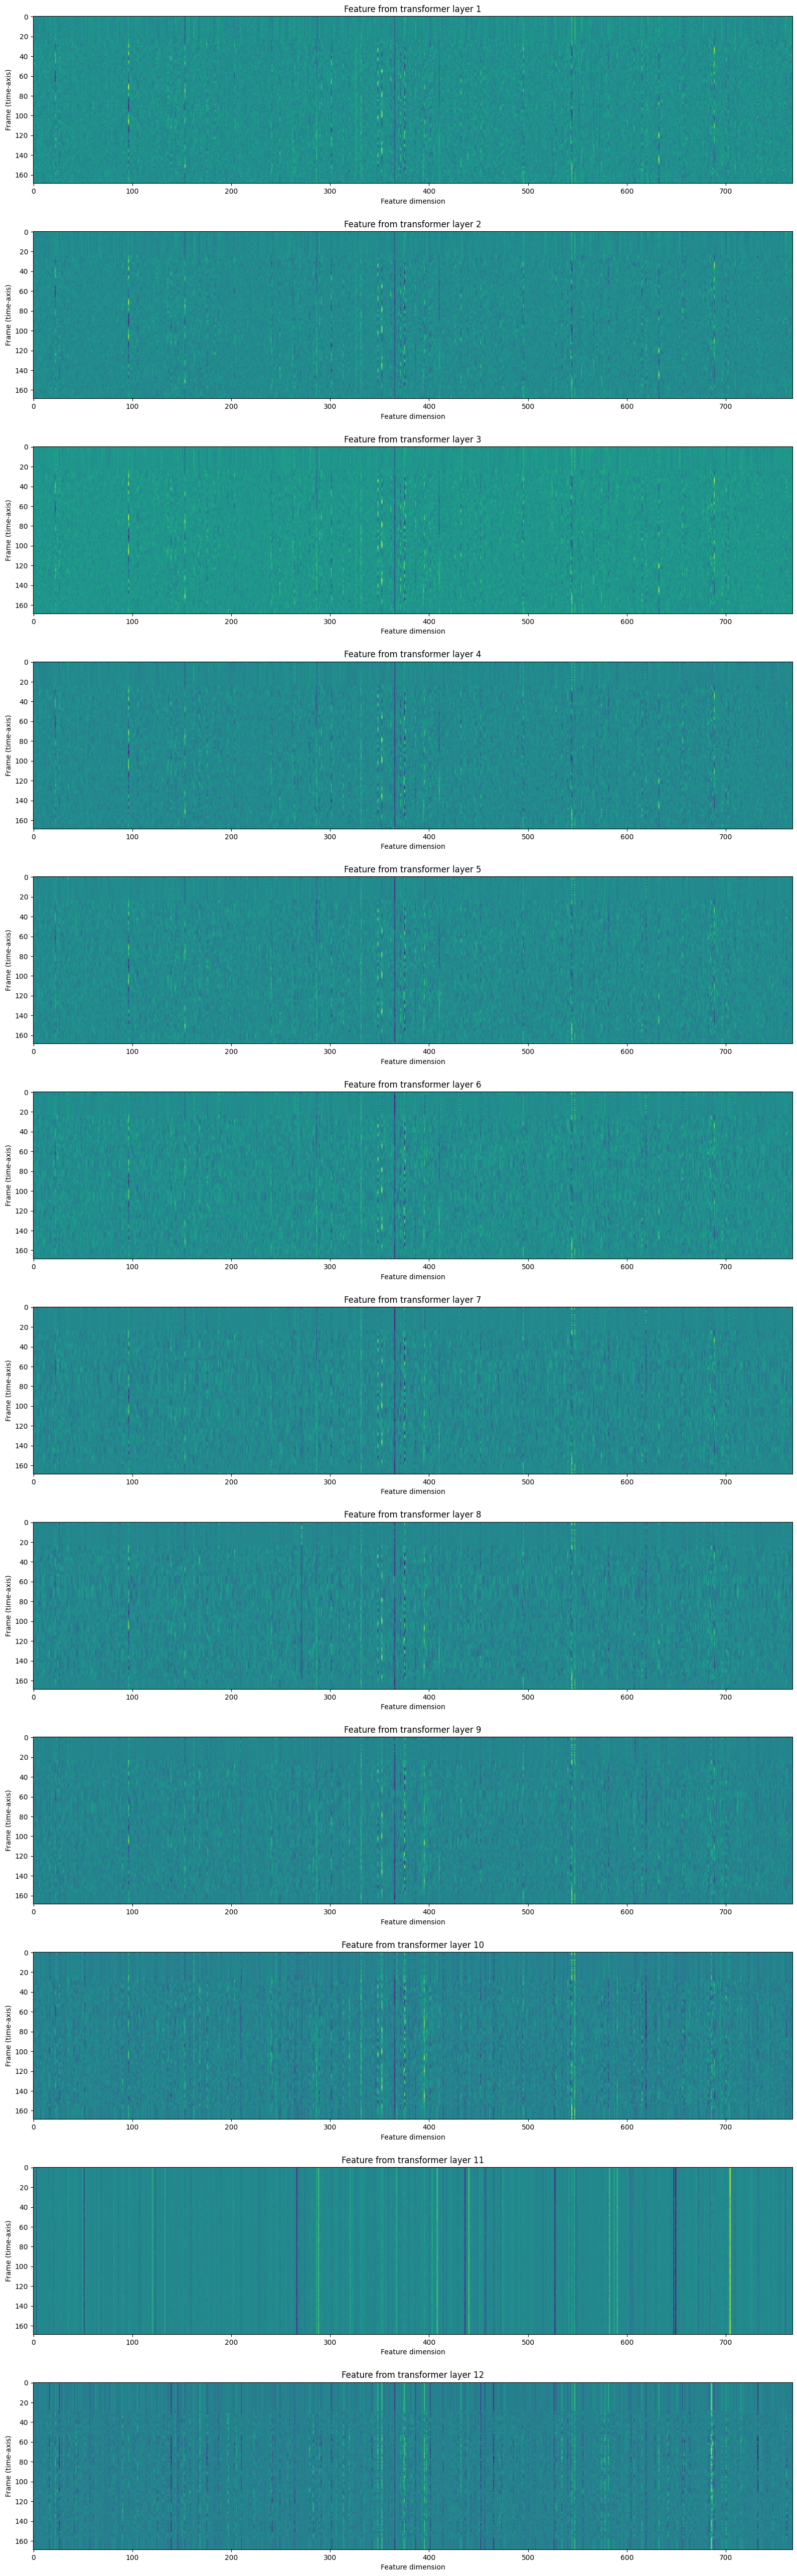

In [11]:
# Create a subplot for visualizing the features
fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))

# Iterate over the extracted features and visualize them
for i, feats in enumerate(features):
    # Display the feature map on the current subplot
    ax[i].imshow(feats[0].cpu())

    # Set title for the subplot indicating the transformer layer
    ax[i].set_title(f"Feature from transformer layer {i+1}")

    # Set labels for the x and y axes
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")

# Adjust layout to prevent overlapping subplots
plt.tight_layout()

# Display the visualization
plt.show()


In [12]:
with torch.inference_mode():
    emission, _ = model(waveform)

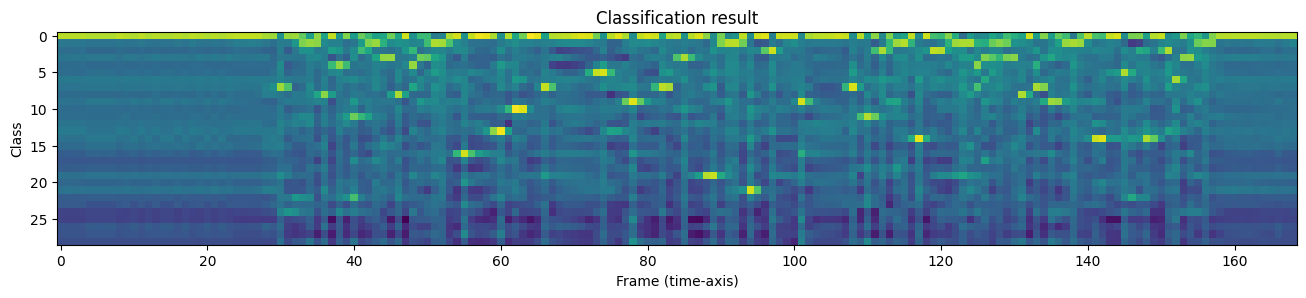

Class labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [13]:
plt.imshow(emission[0].cpu().T)
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.show()
print("Class labels:", bundle.get_labels())

In [14]:
# Define a custom GreedyCTCDecoder class as a PyTorch module
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        """Given a sequence emission over labels, get the best path string
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

        Returns:
          str: The resulting transcript
        """
        # Find the index with the maximum logit for each sequence
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]

        # Remove consecutive duplicates in the indices
        indices = torch.unique_consecutive(indices, dim=-1)

        # Filter out the blank label index
        indices = [i for i in indices if i != self.blank]

        # Convert the indices to characters using the provided labels
        transcript = "".join([self.labels[i] for i in indices])

        return transcript


In [15]:
# Create decoder object
decoder = GreedyCTCDecoder(labels=bundle.get_labels())
transcript = decoder(emission[0])

In [16]:
# check the result
print(transcript)
IPython.display.Audio(SPEECH_FILE)

I|HAD|THAT|CURIOSITY|BESIDE|ME|AT|THIS|MOMENT|
